<a href="https://colab.research.google.com/github/aslankims/DeepCID/blob/master/DeepCID_one_comp_mdl_tf2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.2.0
Number of train images: (15000, 881, 1)
Number of train labels: (15000, 1)


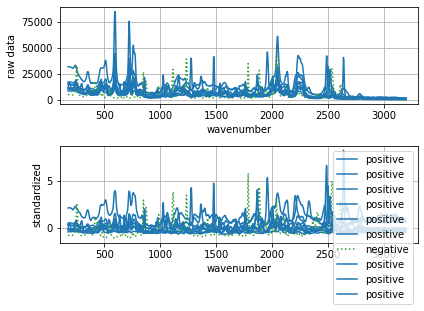

In [ ]:
"""
DeepCID TensorFlow2 with Keras version
Revised on Fri April 3 2020
by D.H.Kim @ KIMS

original TensorFlow1 version created by Zhimin Zhang @ China
"""

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import openpyxl

from sklearn import preprocessing
from tensorflow.python.framework import ops
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


print(tf.__version__)  # Check TensorFlow version

############## LOADING THE INPUT DATA SET ##############
# X.shape = (20000, 881) : 20000 samples, each spectrum has 881 data point.
# There is no data of wavenumber. The Raman shift was in range of 175–3200 cm−1.
# The Raman spectra were standardized including intensity correction and interpolation.

compound = 1   # Specify a component
datafile1 ='/content/drive/My Drive/DeepCID/augmented data/'+str(compound)+'component.npy'
X = np.load(datafile1)
Xtrain0 = X[0:15000]
Xvalid0 = X[15000:17500]
Xtest0 = X[17500:20000]

# Standardization with StandardScaler
scaler = preprocessing.StandardScaler().fit(Xtrain0)
Xtrain = scaler.transform(Xtrain0)
Xvalid = scaler.transform(Xvalid0)
Xtest = scaler.transform(Xtest0)
# save Xscale.npy for scaling new input later #
Xscale = np.array([scaler.mean_, scaler.scale_])
filepath0 = '/content/drive/My Drive/DeepCID/model_cnn/component_'+str(compound)+'/Xscale.npy'
np.save(filepath0, Xscale)
Xtrain = Xtrain.reshape((15000, 881, 1))
Xvalid = Xvalid.reshape((2500, 881, 1))
Xtest = Xtest.reshape((2500, 881, 1))


# Y1 == 1, means that the sample contains the corresponding component
datafile2 ='/content/drive/My Drive/DeepCID/augmented data/'+str(compound)+'label.npy'
Y1 = np.load(datafile2) 
Y2 = np.ones((Y1.shape)) - Y1
# Y = np.concatenate((Y1,Y2), axis=1)  # one-hot encoding
Ytrain = Y1[0:15000]
Yvalid = Y1[15000:17500]
Ytest = Y1[17500:20000]

##### Check the input dataset shape and display some data #####
print("Number of train images: {}".format(Xtrain.shape))
print("Number of train labels: {}".format(Ytrain.shape))

# the data of wavenumber is generated for plotting
wn = np.arange(175, 3200, (3200-175)/881)
wn = wn.T

fig, axs = plt.subplots(2, 1)
i = 0
for i in range(10):
  if Y1[i] == 1:
    axs[0].plot(wn, Xtrain0[i], 'C0', label = "positive")
    axs[1].plot(wn, Xtrain[i], 'C0', label = "positive")
  else:
    axs[0].plot(wn, Xtrain0[i], 'C2:', label = "negative")
    axs[1].plot(wn, Xtrain[i], 'C2:', label = "negative")
axs[0].set_xlim(100, 3300)
axs[0].set_xlabel('wavenumber')
axs[0].set_ylabel('raw data')
axs[0].grid(True)
axs[1].set_xlim(100, 3300)
axs[1].set_xlabel('wavenumber')
axs[1].set_ylabel('standardized')
axs[1].grid(True)
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
############## SETUP THE CNN MODEL ##############
def create_model():
  model = Sequential([
    Conv1D(32, kernel_size=5, strides=2, activation='relu', padding='same', input_shape=(881,1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.5),
    Conv1D(64, kernel_size=5, strides=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Dropout(0.5),
#    Conv1D(128, kernel_size=5, strides=2, activation='relu', padding='same'),
#    BatchNormalization(),
#    MaxPooling1D(pool_size=3, strides=2, padding='same'),
#    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
  ])
  
  adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,
          metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 441, 32)           192       
_________________________________________________________________
batch_normalization_2 (Batch (None, 441, 32)           128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 221, 32)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 221, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 111, 64)           10304     
_________________________________________________________________
batch_normalization_3 (Batch (None, 111, 64)           256       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 56, 64)           

In [ ]:

############## TRAINING and SAVE THE CNN MODEL ##############
# Set the file to save the model
checkpoint_path = '/content/drive/My Drive/DeepCID/model_cnn/component_'+str(compound)+'/CNN_model.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# make callback to save the checkpoint of model
cp_callback = ModelCheckpoint(checkpoint_path, verbose=0)

# Set the batch size and number of epochs to train for
BATCH_SIZE = 50
NUM_EPOCHS = 100

model = create_model()
H = model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
              validation_data=(Xvalid, Yvalid), callbacks = [cp_callback])

#model.save('/content/drive/My Drive/DeepCID/model_cnn/component_'+str(compound)+'/CNN_model.h5')
############################################################

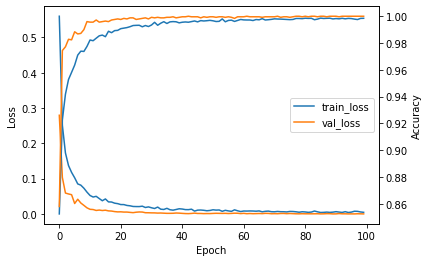

79/79 - 1s - loss: 0.0024 - accuracy: 0.9996
Prediction accuracy for test dataset: 99.96%


In [ ]:
############## CHECK THE TRAINING and TEST THE CNN MODEL ##############
# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(N, H.history["loss"], label="train_loss")
ax1.plot(N, H.history["val_loss"], label="val_loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
plt.legend(loc = "center right")
ax2 = ax1.twinx()
ax2.plot(N, H.history["accuracy"], label="train_acc")
ax2.plot(N, H.history["val_accuracy"], label="val_acc")
ax2.set_ylabel("Accuracy")
ax2.grid(False)
plt.show()

# LOAD THE TRAINED MODEL AND PREDICT THE TEST SET
model.load_weights(checkpoint_path)
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose=2)
print("Prediction accuracy for test dataset: {:5.2f}%".format(100*test_acc))


In [ ]:
model = create_model()
test_loss, test_acc = model.evaluate(Xtest, Ytest, verbose=2)
print("Prediction accuracy for test dataset: {:5.2f}%".format(100*test_acc))

In [ ]:
saved_model = tf.keras.models.load_model('/content/drive/My Drive/DeepCID/model_cnn/component_'+str(compound)+'/CNN_model.h5')
test_loss, test_acc = saved_model.evaluate(Xtest, Ytest, verbose=2)
print("Prediction accuracy for test dataset: {:5.2f}%".format(100*test_acc))

In [ ]:
Ypred_i = saved_model.predict(Xtest)

In [ ]:
Ypred_i

array([[9.9999988e-01, 7.5258846e-08],
       [1.0000000e+00, 1.2773687e-08],
       [1.2721638e-22, 1.0000000e+00],
       ...,
       [8.0978532e-37, 1.0000000e+00],
       [1.0000000e+00, 1.0113643e-13],
       [1.0000000e+00, 5.1562075e-08]], dtype=float32)